# Convolutional Autoencoder

## 1. initialize

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time as tm
import os
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [3]:
np.random.seed(1) # to make the results reproducible

In [4]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [5]:
# Detect the number of train data mini batches. Shuffle them and divide into a train/test parts.

fname_pattern = "./bengaliai-cv19/train_batch_{:03d}.pickle"
train_test_split = 0.7

mbatch_no = 0
while os.path.exists(fname_pattern.format(mbatch_no)):
    mbatch_no = mbatch_no + 1
print("{} train data file(s) found.".format(mbatch_no))

mbatch_train_no = round(mbatch_no * 0.7)
mbatch_test_no = mbatch_no - mbatch_train_no
mbatch_idx = np.random.permutation(mbatch_no)
mbatch_train_idx = mbatch_idx[:mbatch_train_no]
mbatch_test_idx = mbatch_idx[mbatch_train_no:]

197 train data file(s) found.


## 2. Helper functions

In [6]:
def load_batch(mbatch_no):
    fname = fname_pattern.format(mbatch_no)
    with open(fname, "rb") as f:
        batch = pickle.load(f)
        return batch

In [7]:
def prepare_image(img):
    pil_img = PIL.Image.fromarray(img)
    new_pil_img = pil_img.resize((256, 256), PIL.Image.ANTIALIAS)
    return np.array(new_pil_img)

In [8]:
def prepare_batch(batch):
    new_X = np.zeros((batch['X'].shape[0], 256, 256), dtype=float)
    for i in range(new_X.shape[0]):
        new_X[i, :, :] = prepare_image(batch['X'][i, :, :])
    batch['X'] = new_X

In [9]:
def show_model(model):
    return SVG(model_to_dot(model, show_shapes=True, dpi=64).create(prog='dot', format='svg'))

## 3. check

In [10]:
print(tf.test.is_gpu_available())
print(tf.__version__)
print(tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
2.1.0
2.2.4-tf


In [11]:
batch = load_batch(0)
prepare_batch(batch)

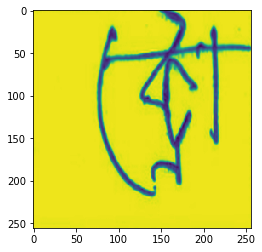

In [12]:
plt.imshow(batch['X'][0])

## 4. model

In [13]:
X = tf.keras.layers.Input(shape=[256, 256, 1], dtype=tf.float32)

Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(X)
B1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
A1 = tf.keras.layers.LeakyReLU(alpha=0.1)(B1)
P1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A1)

Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P1)
B2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
A2 = tf.keras.layers.LeakyReLU(alpha=0.1)(B2)
P2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A2)

Z3 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P2)
B3 = tf.keras.layers.BatchNormalization(axis=3)(Z3)
A3 = tf.keras.layers.LeakyReLU(alpha=0.1)(B3)
P3 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A3)

Z4 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P3)
B4 = tf.keras.layers.BatchNormalization(axis=3)(Z4)
A4 = tf.keras.layers.LeakyReLU(alpha=0.1)(B4)
P4 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A4)

Z5 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P4)
B5 = tf.keras.layers.BatchNormalization(axis=3)(Z5)
A5 = tf.keras.layers.LeakyReLU(alpha=0.1)(B5)
P5 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A5)

Z6 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=[5,5], padding="same")(P5)
B6 = tf.keras.layers.BatchNormalization(axis=3)(Z6)
A6 = tf.keras.layers.LeakyReLU(alpha=0.1)(B6)
U6 = tf.keras.layers.UpSampling2D(size=(2, 2))(A6)

Z7 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=[5,5], padding="same")(U6)
B7 = tf.keras.layers.BatchNormalization(axis=3)(Z7)
A7 = tf.keras.layers.LeakyReLU(alpha=0.1)(B7)
U7 = tf.keras.layers.UpSampling2D(size=(2, 2))(A7)

Z8 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[5,5], padding="same")(U7)
B8 = tf.keras.layers.BatchNormalization(axis=3)(Z8)
A8 = tf.keras.layers.LeakyReLU(alpha=0.1)(B8)
U8 = tf.keras.layers.UpSampling2D(size=(2, 2))(A8)

Z9 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[5,5], padding="same")(U8)
B9 = tf.keras.layers.BatchNormalization(axis=3)(Z9)
A9 = tf.keras.layers.LeakyReLU(alpha=0.1)(B9)
U9 = tf.keras.layers.UpSampling2D(size=(2, 2))(A9)

Z10 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=[5,5], padding="same")(U9)
B10 = tf.keras.layers.BatchNormalization(axis=3)(Z10)
A10 = tf.keras.layers.LeakyReLU(alpha=0.1)(B10)
U10 = tf.keras.layers.UpSampling2D(size=(2, 2))(A10)

model = tf.keras.models.Model(inputs=X, outputs=U10) # Keras 2.2.4 from TensorFlow 2.1.0
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       208       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64    

In [14]:
def fit(img_batch, idx_from, idx_to, epochs):
    mini_img_batch = img_batch[idx_from:idx_to, :, :]
    mini_batch = mini_img_batch.reshape(mini_img_batch.shape[0], mini_img_batch.shape[1], mini_img_batch.shape[2], 1)
    input_X = tf.convert_to_tensor(mini_batch, dtype=tf.float32)
    model.fit(input_X, input_X, epochs=epochs)

In [15]:
def predict(img):
    inp_img = img.reshape(1, img.shape[0], img.shape[1], 1)
    pred_img = model.predict(inp_img)
    ret_img = pred_img.reshape(img.shape[0], img.shape[1])
    return ret_img

## 5. Train

In [16]:
for i, idx in enumerate(mbatch_train_idx):
    print("Batch# {}".format(idx), flush=True)
    batch = load_batch(idx)
    prepare_batch(batch)
    fit(batch['X'], 0, 1024, epochs=100)
    model.save("output/model-{}-{}.h5".format(tm.time(), i))

Batch# 35
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 5s 5ms/sample - loss: 0.4355 - accuracy: 0.2238
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.3716 - accuracy: 0.2666
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.3398 - accuracy: 0.2753
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.3120 - accuracy: 0.2792
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.2872 - accuracy: 0.2815
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.2651 - accuracy: 0.2826
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.2451 - accuracy: 0.2835
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.2269 - accuracy: 0.2841
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.2105 - accuracy: 0.2844
Epoch 10/100
1024/1024 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0138 - accuracy: 0.2854
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0129 - accuracy: 0.2854
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0137 - accuracy: 0.2854
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0126 - accuracy: 0.2854
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0122 - accuracy: 0.2854
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0120 - accuracy: 0.2854
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0117 - accuracy: 0.2854
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0118 - accuracy: 0.2854
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0115 - accuracy: 0.2854
Epoch 87/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2658
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2658
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2658
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2658
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2658
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2658
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2658
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2658
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2658
Epoch 64/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2745
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2745
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0031 - accuracy: 0.2745
Epoch 41/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2756
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2756
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2756
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2756
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2756
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2756
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2756
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2756
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2756
Epoch 18/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2756
Epoch 95/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2956
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2956
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2956
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2956
Epoch 72/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.3024
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.3024
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.3024
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.3024
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.3024
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.3024
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.3024
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.3024
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.3024
Epoch 49/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2833
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2833
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2833
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2833
Epoch 26/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2833
Batch# 18
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2798
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2798
Epoch 3/100
1024/1024 [=====

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2798
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2798
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2798
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2798
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2798
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2798
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2798
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2798
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2798
Epoch 80/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2952
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2952
Epoch 57/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2690
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2690
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2690
Epoch 34/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2774
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2774
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0030 - accuracy: 0.2774
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0030 - accuracy: 0.2774
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 0.2774
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 0.2774
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0028 - accuracy: 0.2774
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0028 - accuracy: 0.2774
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2774
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/s

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2774
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2774
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2774
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2774
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2774
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2774
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2774
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2774
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2774
Epoch 88/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2887
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2887
Epoch 65/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2615
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2615
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2615
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2615
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2615
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2615
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2615
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2615
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2615
Epoch 42/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2774
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2774
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2774
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2774
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2774
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2774
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2774
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2774
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2774
Epoch 19/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2774
Epoch 96/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2879
Epoch 73/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2682
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2682
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2682
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2682
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2682
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2682
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2682
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2682
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2682
Epoch 50/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2862
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2862
Epoch 27/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2862
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2862
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2862
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2862
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2862
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2862
Batch# 53
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2928
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0032 - accuracy: 0.2928
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0030 - accuracy: 0.2928
Epoch 4/100
1024/1024 [======

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2928
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2928
Epoch 81/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2738
Epoch 58/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2893
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2893
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2893
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2893
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2893
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2893
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2893
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2893
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2893
Epoch 35/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0028 - accuracy: 0.2889
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2889
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2889
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2889
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2889
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2889
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2889
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2889
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2889
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2889
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2889
Epoch 89/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2710
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2710
Epoch 66/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2656
Epoch 43/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2749
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2749
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2749
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2749
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2749
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2749
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2749
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2749
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2749
Epoch 20/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2749
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2749
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2749
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2749
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2749
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2749
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2749
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2749
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2749
Epoch 97/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2750
Epoch 74/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2784
Epoch 51/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2860
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2860
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2860
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2860
Epoch 28/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2860
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2860
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2860
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2860
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2860
Batch# 163
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0031 - accuracy: 0.2845
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 0.2845
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2845
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2845
Epoch 5/100
1024/1024 [======

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2845
Epoch 82/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2801
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2801
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2801
Epoch 59/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2987
Epoch 36/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2958
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2958
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2958
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2958
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2958
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2958
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2958
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2958
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2958
Epoch 13/100
1024/1024 [==============================] - 1s 1ms

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2958
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 90/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2505
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2505
Epoch 67/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 44/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2752
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2752
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2752
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2752
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2752
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2752
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2752
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2752
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2752
Epoch 21/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2752
Epoch 98/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2836
Epoch 75/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2802
Epoch 52/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2834
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2834
Epoch 29/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2834
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2834
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2834
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2834
Batch# 185
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 0.2613
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2613
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2613
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2613
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2613
Epoch 6/100
1024/1024 [=======

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2613
Epoch 83/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2746
Epoch 60/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2851
Epoch 37/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2817
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2817
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2817
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2817
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2817
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2817
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2817
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2817
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2817
Epoch 14/100
1024/1024 [==============================] - 1s 1m

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2817
Epoch 91/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2761
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2761
Epoch 68/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2698
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2698
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2698
Epoch 45/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2728
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2728
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2728
Epoch 22/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2728
Epoch 99/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2975
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2975
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2975
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2975
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2975
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2975
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2975
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2975
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2975
Epoch 76/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.3021
Epoch 53/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2845
Epoch 30/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2845
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2845
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2845
Batch# 98
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0029 - accuracy: 0.2813
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2813
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2813
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2813
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2813
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2813
Epoch 7/100
1024/1024 [=========

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2813
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2813
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2813
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2813
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2813
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2813
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2813
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2813
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2813
Epoch 84/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2840
Epoch 61/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2978
Epoch 38/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2900
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2900
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2900
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2900
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2900
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2900
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2900
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2900
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2900
Epoch 15/100
1024/1024 [==============================] - 1s 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2900
Epoch 92/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2966
Epoch 69/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2661
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2661
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2661
Epoch 46/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2877
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2877
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2877
Epoch 23/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2877
Epoch 100/100
1024/1024 [==============================] - 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2841
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 77/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2805
Epoch 54/100
1024/1024 [==============================] - 1

136/136 [==============================] - 0s 1ms/sample - loss: 0.0018 - accuracy: 0.2707
Epoch 23/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0018 - accuracy: 0.2707
Epoch 24/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 25/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 26/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 27/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 28/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 29/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 30/100
136/136 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 0.2707
Epoch 31/100
136/136 [==============================] - 0s 1ms/sample - loss:

136/136 [==============================] - 0s 1ms/sample - loss: 0.0015 - accuracy: 0.2707
Batch# 136
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0030 - accuracy: 0.2851
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2851
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2851
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2851
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2851
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2851
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2851
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2851
Epoch 9/100
1024/1024 [=============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2851
Epoch 86/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2981
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2981
Epoch 63/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2803
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2803
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2803
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2803
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2803
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2803
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2803
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2803
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2803
Epoch 40/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2747
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2747
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2747
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2747
Epoch 17/100
1024/1024 [==============================] - 1s

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2747
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2747
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2747
Epoch 94/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2727
Epoch 71/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2831
Epoch 48/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2698
Epoch 25/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2698
Batch# 124
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2622
Epoch 2/100
1024/1024 [===

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2622
Epoch 79/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2601
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2601
Epoch 56/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2724
Epoch 33/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0027 - accuracy: 0.2770
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2770
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2770
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2770
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2770
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2770
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2770
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2770
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2770
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sa

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2770
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2770
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2770
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2770
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2770
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2770
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2770
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2770
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2770
Epoch 87/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2914
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2914
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2914
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2914
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2914
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2914
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2914
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2914
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2914
Epoch 64/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2727
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2727
Epoch 41/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2676
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2676
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2676
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2676
Epoch 18/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2676
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2676
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2676
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2676
Epoch 95/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 72/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2905
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2905
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2905
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2905
Epoch 49/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2808
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2808
Epoch 26/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2808
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2808
Batch# 12
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2820
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2820
Epoch 3/100
1024/1024 [=====

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2820
Epoch 80/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2797
Epoch 57/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2823
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2823
Epoch 34/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2671
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2671
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2671
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2671
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2671
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2671
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2671
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2671
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2671
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/s

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2671
Epoch 88/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2930
Epoch 65/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2982
Epoch 42/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2816
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2816
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2816
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2816
Epoch 19/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2816
Epoch 96/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2858
Epoch 73/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2697
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2697
Epoch 50/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2804
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2804
Epoch 27/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2804
Batch# 130
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2883
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2883
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2883
Epoch 4/100
1024/1024 [=====

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2883
Epoch 81/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2878
Epoch 58/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2649
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2649
Epoch 35/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2791
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2791
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2791
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2791
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2791
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2791
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2791
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2791
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2791
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2791
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2791
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2791
Epoch 89/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2913
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2913
Epoch 66/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2763
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2763
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2763
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2763
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2763
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2763
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2763
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2763
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2763
Epoch 43/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2924
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2924
Epoch 20/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2924
Epoch 97/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2772
Epoch 74/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2707
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2707
Epoch 51/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2825
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2825
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2825
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2825
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2825
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2825
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2825
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2825
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2825
Epoch 28/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2825
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2825
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2825
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2825
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2825
Batch# 194
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0025 - accuracy: 0.2675
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2675
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2675
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2675
Epoch 5/100
1024/1024 [======

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2675
Epoch 82/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2881
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 59/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2755
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2755
Epoch 36/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2832
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2832
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2832
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2832
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2832
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2832
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2832
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2832
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2832
Epoch 13/100
1024/1024 [==============================] - 1s 1ms

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2832
Epoch 90/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2782
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2782
Epoch 67/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2886
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2886
Epoch 44/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2820
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2820
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2820
Epoch 21/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2820
Epoch 98/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2696
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2696
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2696
Epoch 75/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2861
Epoch 52/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2958
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2958
Epoch 29/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2958
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2958
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2958
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2958
Batch# 148
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0026 - accuracy: 0.2912
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2912
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2912
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2912
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2912
Epoch 6/100
1024/1024 [=======

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2912
Epoch 83/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2738
Epoch 60/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2946
Epoch 37/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2711
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2711
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2711
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2711
Epoch 14/100
1024/1024 [==============================] - 1s 1m

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2711
Epoch 91/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2730
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2730
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2730
Epoch 68/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2725
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2725
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2725
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2725
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2725
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2725
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2725
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2725
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2725
Epoch 45/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2903
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2903
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2903
Epoch 22/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2903
Epoch 99/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2841
Epoch 76/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2701
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2701
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2701
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2701
Epoch 53/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2834
Epoch 30/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2834
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2834
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2834
Batch# 165
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2898
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2898
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2898
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2898
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2898
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2898
Epoch 7/100
1024/1024 [========

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2898
Epoch 84/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2812
Epoch 61/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2845
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2845
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2845
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2845
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2845
Epoch 38/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2915
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2915
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2915
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2915
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2915
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2915
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2915
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2915
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2915
Epoch 15/100
1024/1024 [==============================] - 1s 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2915
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2915
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2915
Epoch 92/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2864
Epoch 69/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2626
Epoch 46/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2874
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2874
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2874
Epoch 23/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2874
Epoch 100/100
1024/1024 [==============================] - 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2831
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2831
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2831
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2831
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2831
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2831
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2831
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2831
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2831
Epoch 77/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2806
Epoch 54/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2799
Epoch 31/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2799
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2799
Batch# 143
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2943
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2943
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2943
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2943
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2943
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2943
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2943
Epoch 8/100
1024/1024 [=========

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2943
Epoch 85/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2825
Epoch 62/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2795
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2795
Epoch 39/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2865
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2865
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2865
Epoch 16/100
1024/1024 [==============================] - 1s 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Epoch 93/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 63/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 64/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 65/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 66/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2798
Epoch 67/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 68/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 69/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2798
Epoch 70/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2872
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 40/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2872
Epoch 41/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 42/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 43/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 44/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 45/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 46/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2872
Epoch 47/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2686
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2686
Epoch 24/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 94/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 95/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 96/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 97/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Epoch 98/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0016 - accuracy: 0.2686
Epoch 99/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0016 - accuracy: 0.2686
Epoch 100/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2686
Batch# 100
Train on 1024 samples
Epoch 1/100
1024/1024 [==

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 70/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 71/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 72/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 73/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 74/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 75/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 76/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 77/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2922
Epoch 78/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 47/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 48/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 49/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 50/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 51/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 52/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 53/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 54/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2881
Epoch 55/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2865
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2865
Epoch 26/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 27/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 28/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 29/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 30/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 31/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2865
Epoch 32/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2865
Batch# 126
Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0024 - accuracy: 0.2956
Epoch 2/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0023 - accuracy: 0.2956
Epoch 3/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2956
Epoch 4/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0022 - accuracy: 0.2956
Epoch 5/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2956
Epoch 6/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2956
Epoch 7/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2956
Epoch 8/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2956
Epoch 9/100
1024/1024 [===========

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 78/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 79/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 80/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 81/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 82/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 83/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 84/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 85/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2956
Epoch 86/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2699
Epoch 55/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2699
Epoch 56/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0018 - accuracy: 0.2699
Epoch 57/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 58/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 59/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 60/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 61/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 62/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2699
Epoch 63/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 32/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 33/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 34/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 35/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 36/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 37/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 38/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 39/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2840
Epoch 40/100
1024/1024 [==============================] - 1

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0021 - accuracy: 0.2807
Epoch 9/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 10/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 11/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 12/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 13/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 14/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0020 - accuracy: 0.2807
Epoch 15/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2807
Epoch 16/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0019 - accuracy: 0.2807
Epoch 17/100
1024/1024 [==============================] - 1s

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 86/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 87/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 88/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 89/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 90/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 91/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 92/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 93/100
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0017 - accuracy: 0.2807
Epoch 94/100
1024/1024 [==============================] - 1

In [18]:
test_batch = load_batch(mbatch_test_idx[0])
prepare_batch(test_batch)

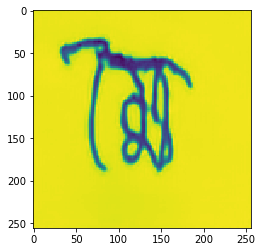

In [19]:
plt.imshow(predict(test_batch['X'][0]))

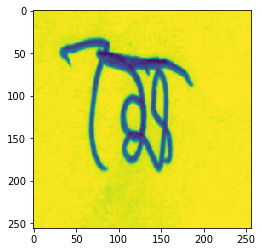

In [20]:
plt.imshow(test_batch['X'][0])